# OTalign 200 cell lines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.decomposition import PCA
import scanpy as sc
import math
from joblib import Parallel, delayed

from scipy.stats import norm
from scipy.spatial.distance import cdist

import pandas as pd

from matplotlib import animation, rc
from IPython.display import HTML

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/'
sys.path.append(DATA_PATH)

In [2]:
import ot

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_discrepancy_nn(Xs, Xt, n_neighbors=3):
    nns = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xs).kneighbors_graph(Xs).toarray()
    nnt = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(Xt).kneighbors_graph(Xt).toarray()
    D = nnt - nns
    return np.linalg.norm(D, axis=0).astype(float)/n_neighbors

def cosine_pairwise_distance(X):        
    n = np.linalg.norm(X, axis=1)
    X = np.dot(np.diag(1/n), X)
    return cdist(X, X)

def compute_discrepancy_d(Xs, Xt):
    Ds = cosine_pairwise_distance(Xs)
    Dt = cosine_pairwise_distance(Xt)
    D = Ds - Dt
    return 1 / np.linalg.norm(D, axis=1)
    
def OT_raw(Xs, Yt, alph=1, bet=1):
    w_x, w_y = np.ones((len(Xs),))/len(Xs), np.ones((len(Yt),))/len(Yt)
    M = ot.dist(Xs, Yt)**alph
    M /= M.max()
    Gs = ot.sinkhorn(w_x, w_y, M, 1e-3)
    return np.dot(np.diag(1/w_x), np.dot(Gs, Yt))

def OT_regularized_nn(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_regularized_d(Xs, Yt, alph=1, bet=1):
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = 1 - compute_discrepancy_d(Xs, Xt)
    return np.dot(np.diag(lambdas), Xt - Xs) + Xs

def OT_oob(Xs, Yt, alph=1, bet=1, n_neighbors=3):
    n = len(Xs)
    Xt = OT_raw(Xs, Yt, alph, bet)
    lambdas = compute_discrepancy_nn(Xs, Xt, n_neighbors)
    return np.hstack((Xt, np.reshape(lambdas, (n, 1))))

def update_clouds(angle, ax, clouds):
    ax.view_init(30, angle)
    ax.legend()
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    return clouds

In [3]:
plt.style.use('dark_background')

In [4]:
df = pd.read_csv(DATA_PATH + "all_tumors_pp_ICs.csv", index_col=0)
df

,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,Cell_line
Cells,,,,,,,,,,,,,,,,
AAAGATGCAGTTAACC-1-18-0,-459.273019,-99.719000,505.566067,-519.114922,169.847575,424.536166,-299.121371,116.057499,-106.598212,77.995203,5.576831,90.426192,-84.181949,-155.222429,92.378606,JHH7_LIVER
AACACGTAGACAGACC-1-18-0,-478.774515,178.630990,421.437251,-533.562986,284.366121,214.053055,-677.596930,368.076459,-172.676563,-75.932147,84.548938,59.592393,3.305337,-321.780319,180.195851,JHH7_LIVER
AACTCAGAGCGACGTA-1-18-0,-1051.309756,556.437037,258.953507,-797.287721,583.002547,420.020011,-776.948234,362.052093,-281.485070,51.031295,70.308815,-59.425816,-110.605379,-369.345908,94.166193,JHH7_LIVER
AACTCAGAGGTGCTAG-1-18-0,-321.972861,-121.400228,404.064765,-569.280165,104.051543,221.087551,-142.273235,227.717972,-74.066529,65.799318,-22.533060,-14.224675,-187.831258,-241.859425,-5.026453,JHH7_LIVER
AACTTTCAGATAGGAG-1-18-0,-665.343220,-11.258566,638.515797,-850.381385,116.533049,159.868563,-370.795667,287.936557,-94.601118,62.628048,35.066629,-16.878444,-351.609332,-96.789859,126.303109,JHH7_LIVER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCTCCTTCAGCGACC-12-10-21,322.325904,352.770239,60.981889,651.414622,65.253577,-720.220860,464.040302,35.644125,127.001891,317.120433,219.426361,230.793803,173.595164,484.667149,-218.424113,HS729_SOFT_TISSUE
TTGCCGTGTAACGTTC-12-10-21,265.691919,100.153499,108.466144,567.538490,-16.043168,-661.138942,690.405381,-39.719779,124.096445,214.083750,145.419761,220.937859,138.363664,544.678195,-138.847494,HS729_SOFT_TISSUE
TTGTAGGCACATCCAA-12-10-21,-519.169840,396.303187,-208.636064,-322.383344,299.332509,18.559136,-123.652939,-159.495100,-188.274307,364.818837,-0.348277,-44.838243,-145.566006,-63.403952,-33.393872,HS729_SOFT_TISSUE


In [5]:
def to_numpy(df, cols, cell_line=None):
    target_X = df[cols].values
    if cell_line is not None:
        target_X = target_X[df['Cell_line'].str.contains(cell_line)]
    return target_X

In [6]:
# JHU011
ics = ['IC%i' % i for i in (2, 3, 8, 10)]
target_X = to_numpy(df, ics, 'JHU011')

In [7]:
Xs_before = []
Xs_raw = []
Xs_regularized_nn = []
Xs_regularized_d = []
labels = []
n = len(set(df['Cell_line']))
for i, cl in enumerate(set(df['Cell_line'])):
    source_X = to_numpy(df, ics, cl)
    if len(source_X) < 20 or cl == 'JHU011':
        continue
    print( ('[%i/%i] Computing cell line %s...' % (i+1, n, cl)) + ' '*30, end='\r')
    Xs_before.append(source_X)
    labels.append(cl)
    Xs_raw.append(OT_raw(source_X, target_X))
    Xs_regularized_nn.append(OT_regularized_nn(source_X, target_X, n_neighbors=5))
    Xs_regularized_d.append(OT_regularized_d(source_X, target_X))

/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)
/home/risitop/.local/share/virtualenvs/new_pipenv-jbJWqQFO/lib/python3.8/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)


In [ ]:
def batch_computation(X, f, k=10):
    n = len(X)
    step = int(n/k)
    presults = []
    for i in range(k+1):
        print('[%i/%i] Computing batch...' % (i + 1, k+1), end='\r')
        presults.append(f(X[i*step:(i+1)*step,:]))
    return np.hstack(presults)

def density(Xt, sigma=100):
    def one_step(X):        
        return norm.pdf(cdist(X, Xt), scale=sigma).sum(axis=1)
    return batch_computation(Xt, one_step, k=4)
    
densities = [density(np.vstack(X_)) for X_ in [Xs_before, Xs_raw, Xs_regularized_nn, Xs_regularized_d]]

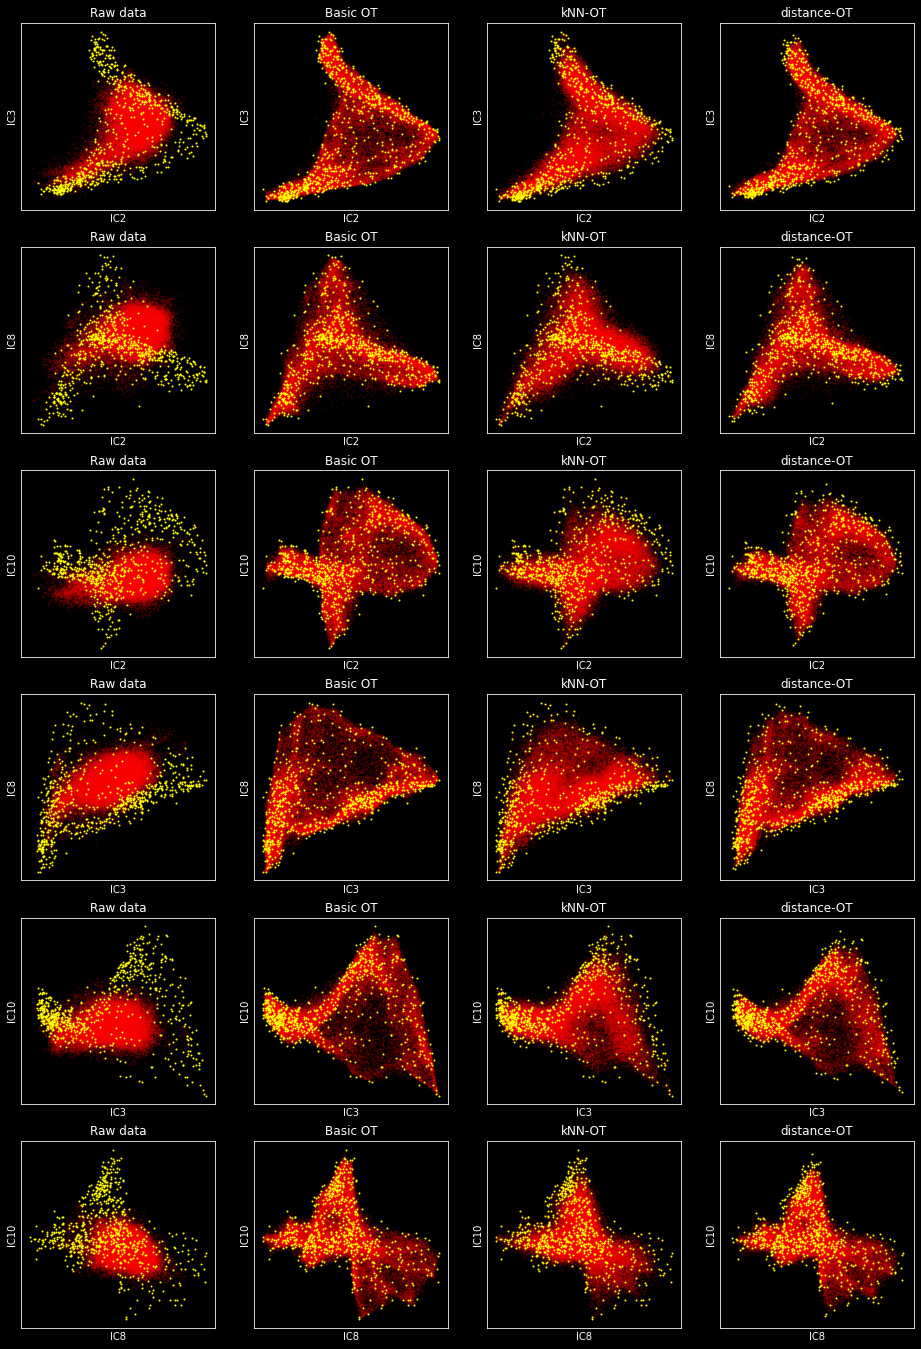

In [8]:
def find_pcs(k):
    if k == 0:
        return 0, 1
    if k == 1:
        return 0, 2
    if k == 2:
        return 0, 3
    if k == 3:
        return 1, 2
    if k == 4:
        return 1, 3
    if k == 5:
        return 2, 3
    
ICS = [2, 3, 8, 10]

plt.figure(figsize=(16,24))
Xs = [Xs_before, Xs_raw, Xs_regularized_nn, Xs_regularized_d]
for i, (X, method) in enumerate(zip(Xs, ['Raw data', 'Basic OT', 'kNN-OT', 'distance-OT'])):
    X = np.vstack(X + [target_X])
    thr = len(X) - len(target_X)
    for j in range(6):
        plt.subplot(6,4,i+j*4+1)
        k, l = find_pcs(j)
        plt.scatter(X[:thr,k], X[:thr,l], s=1, alpha=0.1, c='red')
        plt.scatter(X[thr:,k], X[thr:,l], s=1, alpha=1, c='yellow')
        plt.xlabel("IC%i" % ICS[k])
        plt.ylabel("IC%i" % ICS[l])
        plt.xticks([])
        plt.yticks([])
        plt.title(method)

In [9]:
labels = ['Other cell lines', 'JHU011 cell lines']
alphas = [0.1, 1]

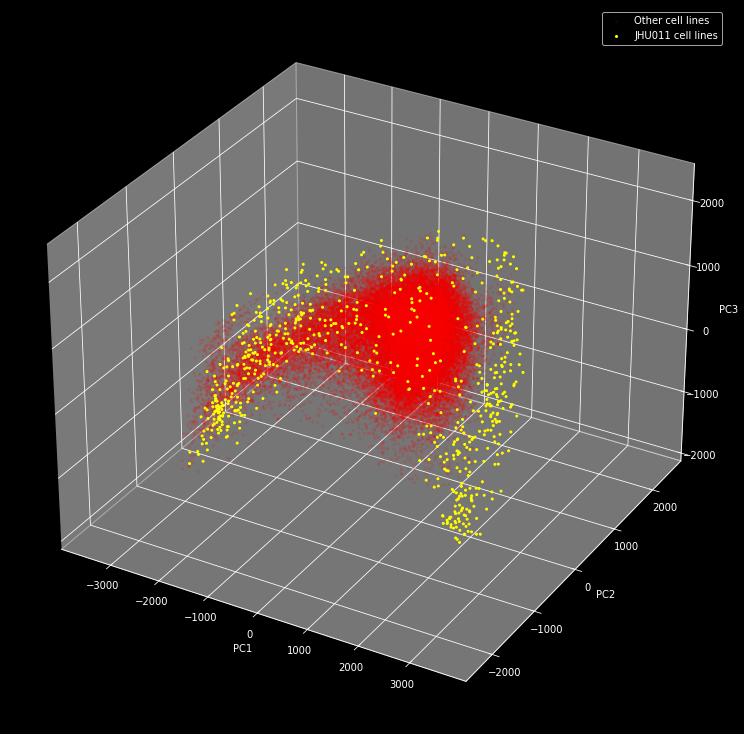

In [10]:
fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_before + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)

clouds_std = [ax.scatter(X_[:,0], X_[:,1], X_[:,2], s=4, label=l, c=c, alpha=a) 
              for (X_, l, c, a) in zip([X[:thr], X[thr:]], labels, ['red', 'yellow'], alphas)]

ani_noOT = animation.FuncAnimation(fig, update_clouds, 360, fargs=(ax, clouds_std),
                                   interval=50, blit=False)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
HTML(ani_noOT.to_html5_video())

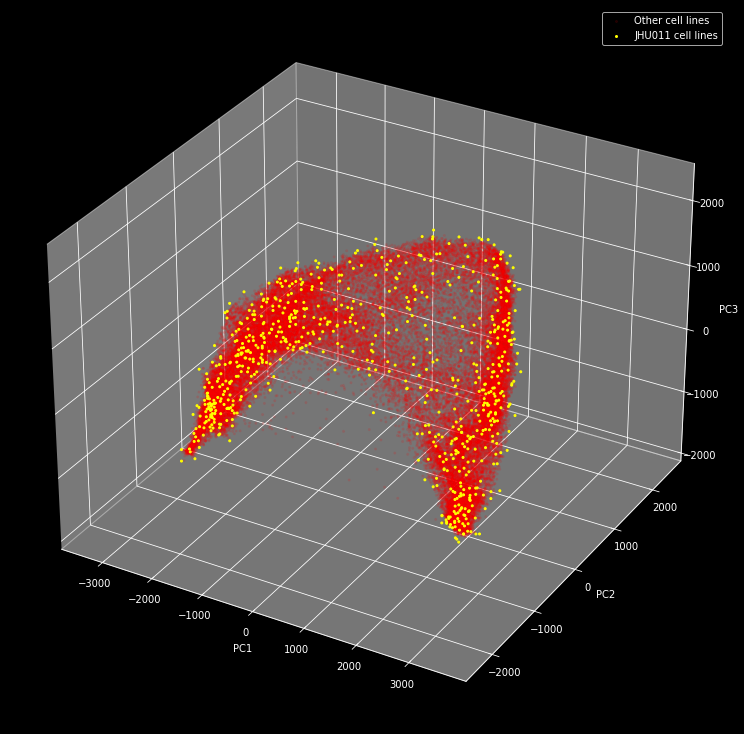

In [11]:
fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_raw + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)

clouds_std = [ax.scatter(X_[:,0], X_[:,1], X_[:,2], s=4, label=l, c=c, alpha=a) 
              for (X_, l, c, a) in zip([X[:thr], X[thr:]], labels, ['red', 'yellow'], alphas)]

ani_OTraw = animation.FuncAnimation(fig, update_clouds, 360, fargs=(ax, clouds_std),
                                   interval=50, blit=False)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
HTML(ani_OTraw.to_html5_video())

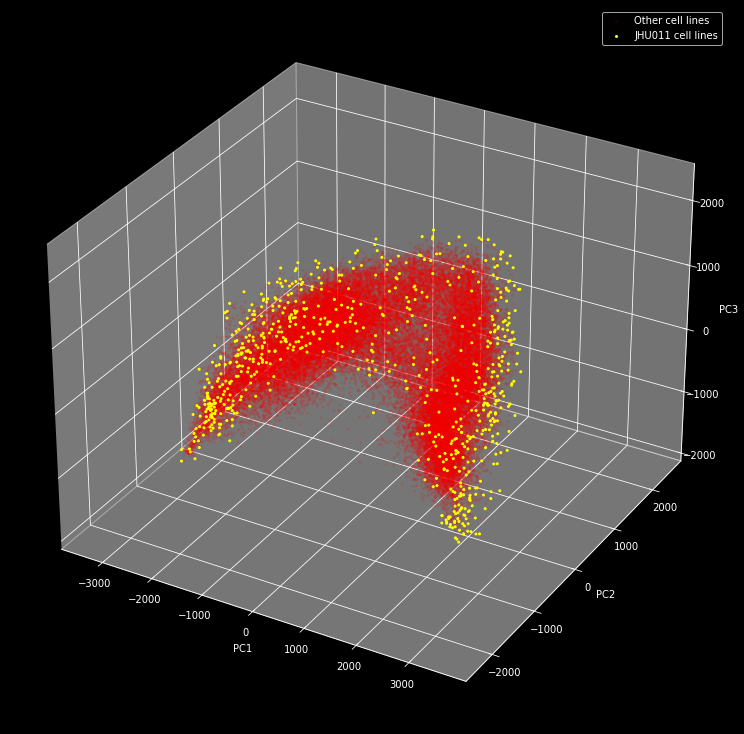

In [12]:
fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_regularized_nn + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)

clouds_std = [ax.scatter(X_[:,0], X_[:,1], X_[:,2], s=4, label=l, c=c, alpha=a) 
              for (X_, l, c, a) in zip([X[:thr], X[thr:]], labels, ['red', 'yellow'], alphas)]

ani_OTnn = animation.FuncAnimation(fig, update_clouds, 360, fargs=(ax, clouds_std),
                                   interval=50, blit=False)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
HTML(ani_OTnn.to_html5_video())

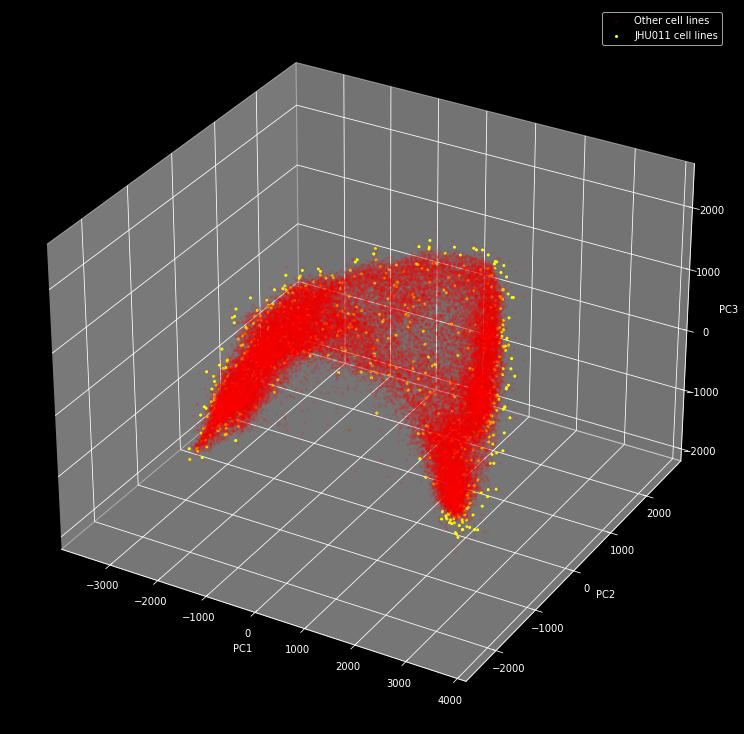

In [13]:
fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

pca = PCA(n_components=3, svd_solver='arpack')
pca.fit(target_X)

X = np.vstack(Xs_regularized_d + [target_X])
X = pca.transform(X)
thr = len(X) - len(target_X)

clouds_std = [ax.scatter(X_[:,0], X_[:,1], X_[:,2], s=4, label=l, c=c, alpha=a) 
              for (X_, l, c, a) in zip([X[:thr], X[thr:]], labels, ['red', 'yellow'], alphas)]

ani_OTd = animation.FuncAnimation(fig, update_clouds, 360, fargs=(ax, clouds_std),
                                   interval=50, blit=False)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
HTML(ani_OTd.to_html5_video())